In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

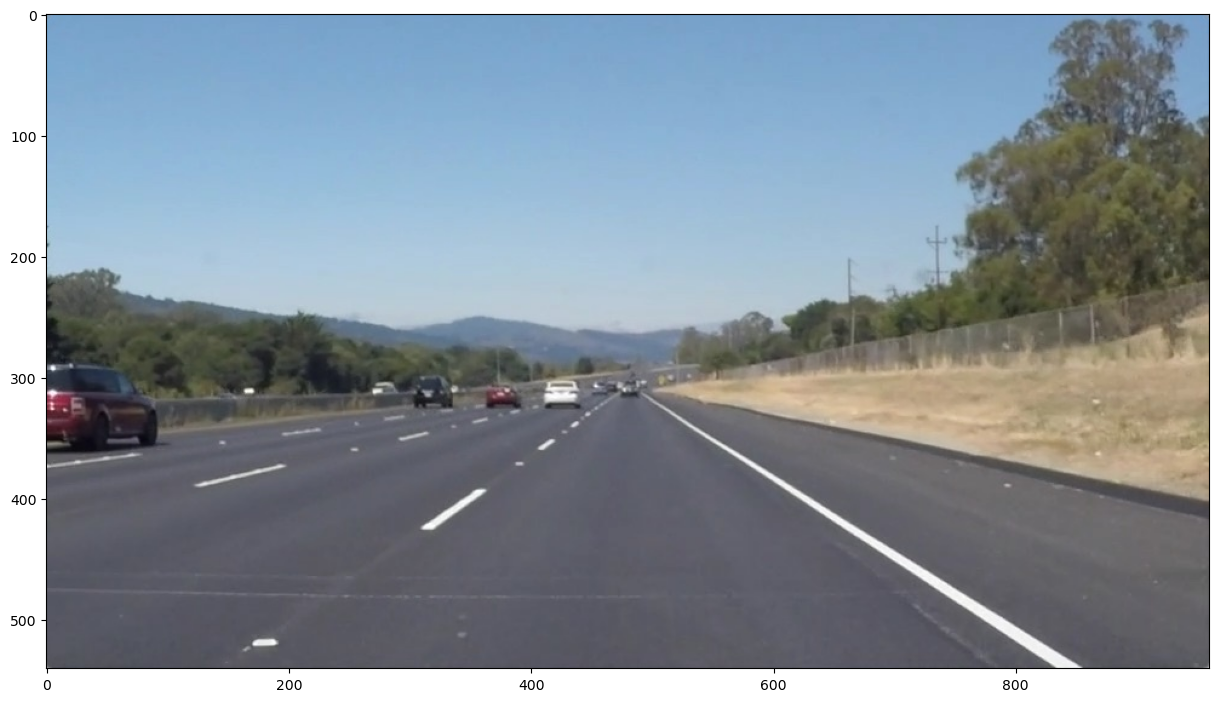

In [2]:
# Reading the image.
img = cv2.imread('test_img1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15, 10))
plt.imshow(img)

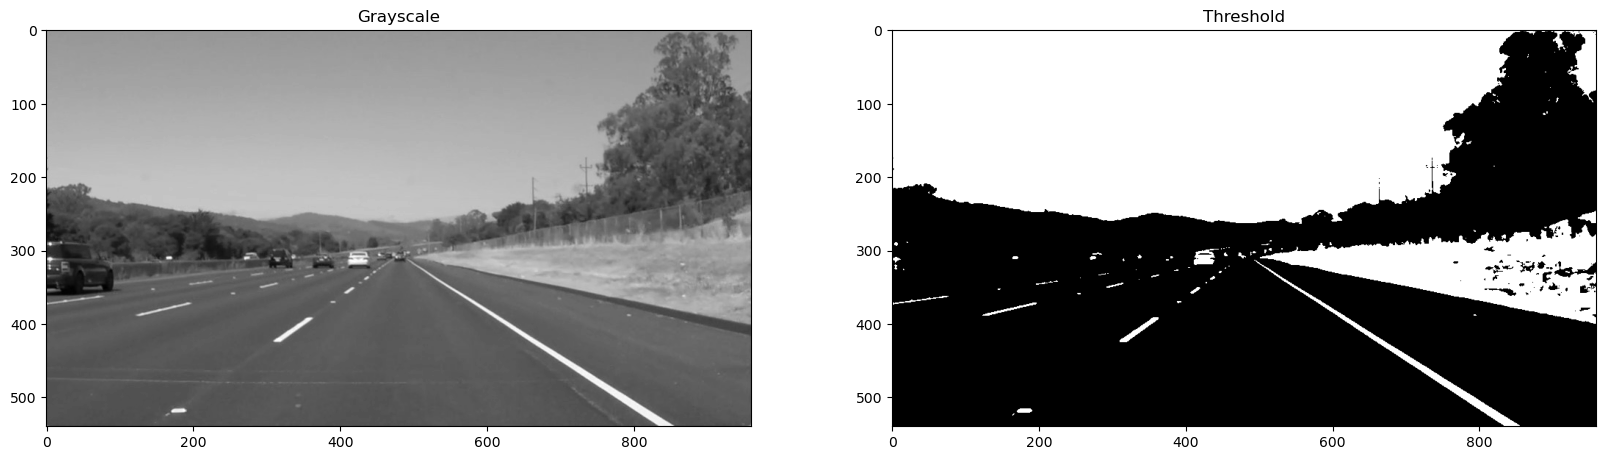

In [3]:
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(gray, 150, 255)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(gray, cmap = 'gray');      plt.title('Grayscale');
plt.subplot(1,2,2); plt.imshow(threshold, cmap = 'gray'); plt.title('Threshold');

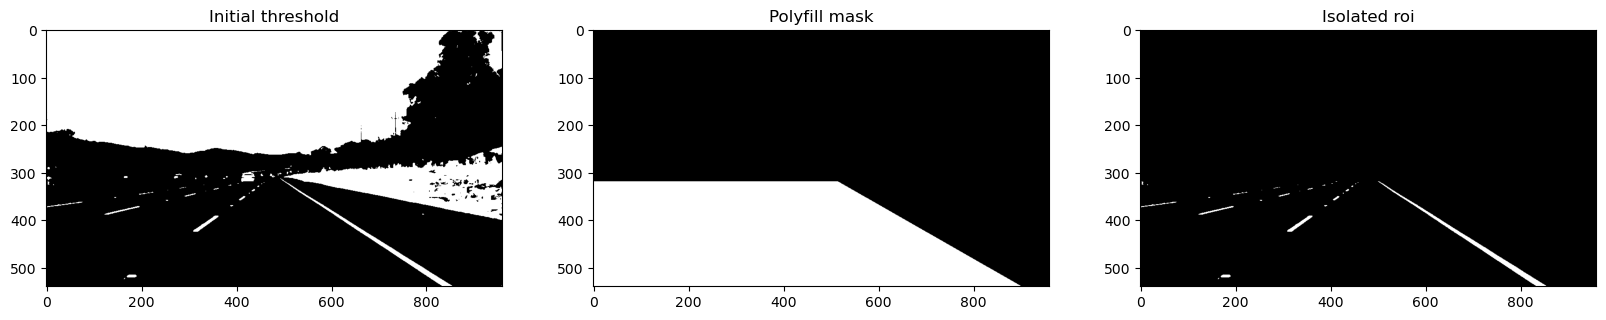

In [11]:
 #  Region masking: Select vertices according to the input image.
roi_vertices = np.array([[[0, 540],
                          [900, 540],
                          [515, 320],
                          [0, 320]]])

# Defining a blank mask.
mask = np.zeros_like(threshold)   

# Defining a 3 channel or 1 channel color to fill the mask.
if len(threshold.shape) > 2:
    channel_count = threshold.shape[2]  # 3 or 4 depending on the image.
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

# Filling pixels inside the polygon.
cv2.fillPoly(mask, roi_vertices, ignore_mask_color)

# Constructing the region of interest based on where mask pixels are nonzero.
roi = cv2.bitwise_and(threshold, mask)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,3,1); plt.imshow(threshold, cmap = 'gray'); plt.title('Initial threshold')
plt.subplot(1,3,2); plt.imshow(mask, cmap = 'gray');      plt.title('Polyfill mask')
plt.subplot(1,3,3); plt.imshow(roi, cmap = 'gray');       plt.title('Isolated roi');

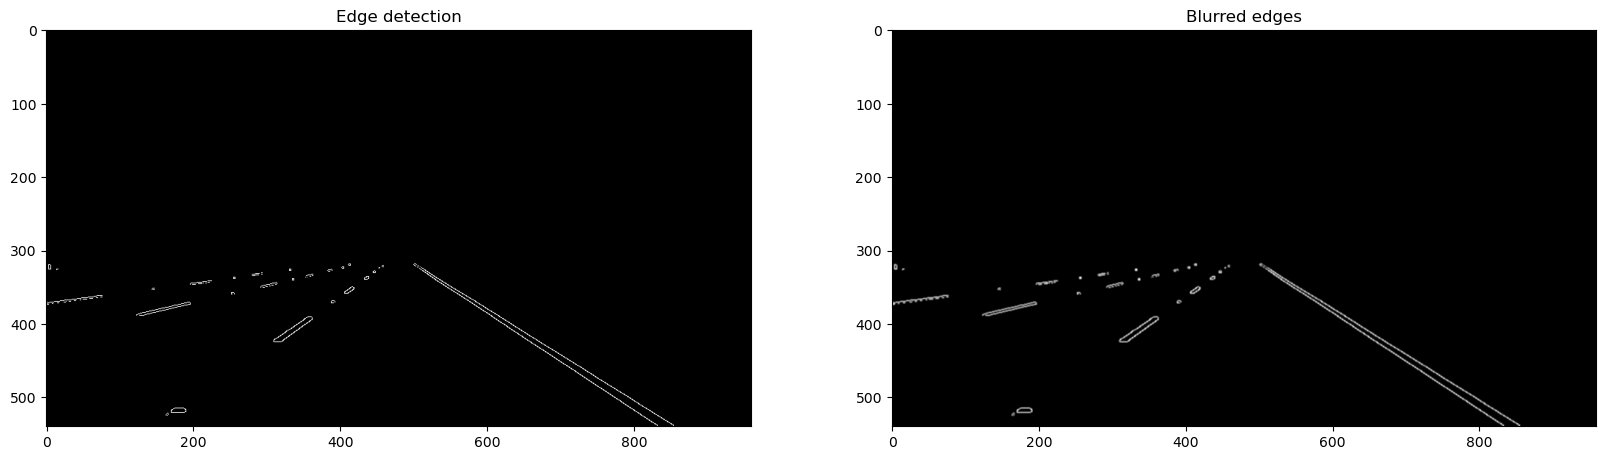

In [20]:
# Perform Edge Detection.
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(roi, low_threshold, high_threshold)

# Smooth with a Gaussian blur.
kernel_size = 3
canny_blur = cv2.GaussianBlur(edges, (kernel_size, kernel_size), 0)

# Display images.
plt.figure(figsize = (20, 10))
plt.subplot(1,2,1); plt.imshow(edges, cmap = 'gray'); plt.title('Edge detection')
plt.subplot(1,2,2); plt.imshow(canny_blur, cmap = 'gray'); plt.title('Blurred edges');

In [21]:
def draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Found 40 lines, including: [[500 322 833 538]]


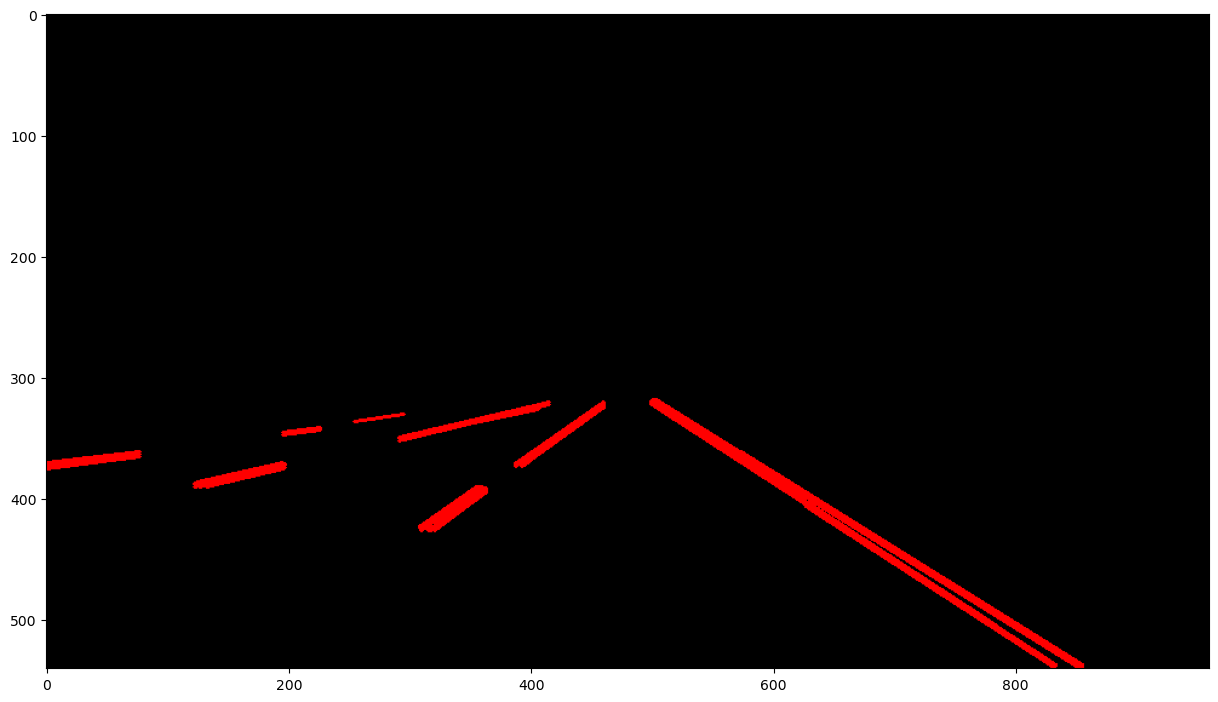

In [22]:
# Hough transform parameters set according to the input image.
rho = 1
theta = np.pi / 180
threshold = 50
min_line_len = 10
max_line_gap = 20

lines = cv2.HoughLinesP(
    canny_blur, rho, theta, threshold, minLineLength = min_line_len, maxLineGap = max_line_gap)

# Draw all lines found onto a new image.
hough = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
draw_lines(hough, lines)

print("Found {} lines, including: {}".format(len(lines), lines[0]))
plt.figure(figsize = (15, 10)); plt.imshow(hough);

In [15]:
def separate_left_right_lines(lines):
    """Separate left and right lines depending on the slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2: # Negative slope = left lane.
                    left_lines.append([x1, y1, x2, y2])
                elif y1 < y2: # Positive slope = right lane.
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

In [16]:
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == 'NoneType'):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n

In [17]:
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            slope = (y1-y2) / (x1-x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)
    
    # Calculate average intersection at lower_border.
    x_lane_lower_point = int((lower_border - avg_consts) / avg_slope)
    
    # Calculate average intersection at upper_border.
    x_lane_upper_point = int((upper_border - avg_consts) / avg_slope)
    
    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

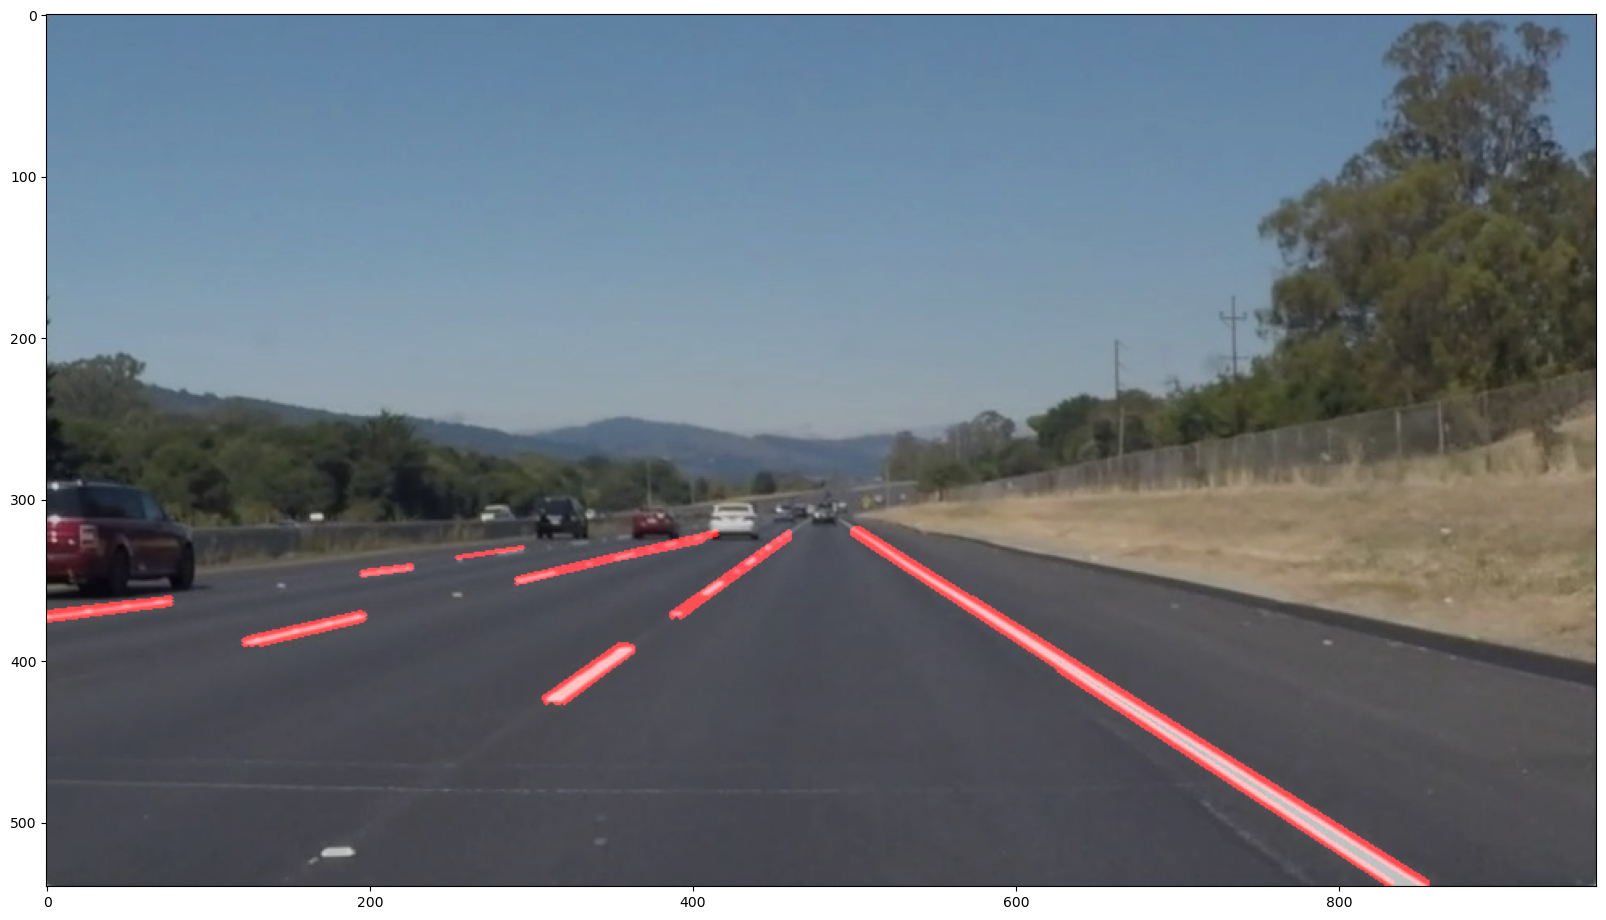

In [23]:
alpha = 0.8
beta = 1.0
gamma = 0.0
image_annotated = cv2.addWeighted(img, alpha, hough, beta, gamma)

# Display the results, and save image to file.
fig = plt.figure(figsize = (20, 20))
plt.imshow(image_annotated)
image_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Lane1-image.jpg', image_annotated);